# Quora Question Pairs - Kaggle Competition (Part I)

This competition was launched in March 2017 by Quora, hosted by Kaggle. Quora is a place to gain and share knowledge — about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term. So, the goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. 

**In this notebook, things I will be look at include:** 

- Exploration of training dataset 
- Performance of naive predictor 
- Basic feature extraction and benchmark model building


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

### `train.csv`

In [2]:
data = pd.read_csv('./data/train.csv')
print("The training dataset has {} rows and {} columns".format(*data.shape))
data.head()

The training dataset has 404290 rows and 6 columns


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# review some sample pairs
print("Example question pair:")
print("Question 1: {}".format(data.question1[1000]))
print("Question 2: {}".format(data.question2[1000]))
print("Duplicaets?: {}".format(data.is_duplicate[1000]))

print("\nExample question pair:")
print("Question 1: {}".format(data.question1[5000]))
print("Question 2: {}".format(data.question2[5000]))
print("Duplicaets?: {}".format(data.is_duplicate[5000]))

print("\nExample question pair:")
print("Question 1: {}".format(data.question1[15000]))
print("Question 2: {}".format(data.question2[15000]))
print("Duplicaets?: {}".format(data.is_duplicate[15000]))

Example question pair:
Question 1: How can I convert raw files to JPEG in photos in a MacBook?
Question 2: How do you convert raw files to JPEG?
Duplicaets?: 0

Example question pair:
Question 1: How do you recharge a AA battery?
Question 2: How can you recharge regular AA batteries?
Duplicaets?: 1

Example question pair:
Question 1: What are the best sites to download movies?
Question 2: Which are best sites to download movies?
Duplicaets?: 1


*Note:* the labels have been supplied by human expert. 0 - not duplicate, 1 - duplicate

In [5]:
# are there null values?
pd.isnull(data).sum()

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

*There are two rows with question 2 being null.*

In [6]:
# Look at the null entries
data[pd.isnull(data['question2'])]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [7]:
# remove the null entries
data = data[~pd.isnull(data['question2'])]

In [7]:
data.to_csv('./data/train_no_null.csv', index=False)

In [8]:
# Some other things to check:
# 1. are there pairs with the same question (qid1 = qid2 in a pair)?
print("Number of pairs with the same question (qid1=qid2 in a pair): \
{}".format(len([(q1, q2) for (q1, q2) in zip(data.qid1, data.qid2) if q1 == q2])))

# 2. are there duplicated pairs? 
qid_pairs = [(q1, q2) for (q1, q2) in zip(data.qid1, data.qid2)]
qid_pairs_reverse = [(q2, q1) for (q1, q2) in zip(data.qid1, data.qid2)]
print("Number of duplicated pairs (with the same qid combination): \
{}".format(len(qid_pairs + qid_pairs_reverse) - len(set(qid_pairs + qid_pairs_reverse))))

Number of pairs with the same question (qid1=qid2 in a pair): 0
Number of duplicated pairs (with the same qid combination): 0


*Good. No duplicated pairs or pairs with the same question.*

The percentage of duplicated question pairs: 36.92%


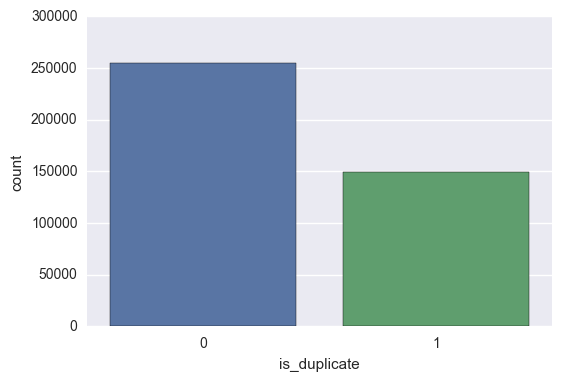

In [9]:
# class distribution: duplicated questions (with 1 for label 'is_duplicate') in the training set
total_pairs = data.shape[0]
duplicated_pairs = data.is_duplicate.sum()
duplicates_pct = 100 * duplicated_pairs/total_pairs
print("The percentage of duplicated question pairs: {:.2f}%".format(duplicates_pct))

# plot countplot
sns.countplot(x = 'is_duplicate', data = data);

*In the over 400,000 training examples, around 36% of the question pairs are duplicated.* 

### `test.csv`
*Note*: Kaggle has supplemented the test set with computer-generated question pairs. 

In [10]:
test = pd.read_csv('./data/test.csv')
print("The training dataset has {} rows and {} columns".format(*test.shape))
test.head()

The training dataset has 2345796 rows and 3 columns


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [11]:
# are there null values?
pd.isnull(test).sum()

test_id      0
question1    2
question2    4
dtype: int64

In [12]:
# rows with question 1 being null
test[pd.isnull(test['question1'])]

,test_id,question1,question2
1046690,1046690,NaN,How I what can learn android app development?
1461432,1461432,NaN,How distinct can learn android app development?


In [13]:
# rows with question 2 being null
test[pd.isnull(test['question2'])]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1270024,1270024,How I can learn app development?,NaN


## 2. Naive Classifier - Constant Prediction

**Apparently, Kaggle uses log loss metric and takes class probabilities instead of class labels in this competition.** Log loss quantifies the accuracy of a classifier by penalising false classifications. And the goal is to effectively minimising the log loss, which is basically equivalent to maximising the accuracy of the classifier. 

In order to calculate log loss, the classifier must assign a probability to each class rather than simply yielding the most likely class. For a binary classifier with a true label y∈{0,1} and a probability estimate p=Pr(y=1), the log loss per sample is the negative log-likelihood of the classifier given the true label:
$LogLoss(y,p)=−logPr(y|p)=−(ylog(p)+(1−y)log(1−p))$
 
A perfect classifier would have a log loss of precisely zero. Less ideal classifiers have progressively larger values of log loss. Log loss heavily penalises classifiers that are confident about an incorrect classification. So, it’s better to be somewhat wrong than emphatically wrong. 

Two approaches to dealing with poor classifications:
- Examine the problematic observations relative to the full data set, remove outliers from the data and re-train the classifier.
- Consider smoothing the predicted probabilities to have a less “certain” classifier to improve the overall log loss.

A naive classifier in this case would be to use a constant probability for all test examples. For example, we can predict the probability of question pairs being duplicate as all 1's, i.e., the `'is_duplicate'` fields are all 1's. Of course, this is not what we want to do in reality, but we can calculate some performance metrics for our reference. Similarly, some probability numbers we can try include 0.5, or 0.369 (the positive class distribution in the training set). 

### p = 1

In [15]:
# A naive predictor that classifies all questions as duplicates, i.e., predict all 1's for 'is_duplicate'
accuracy = duplicated_pairs/total_pairs
precision = duplicated_pairs/total_pairs
recall = duplicated_pairs/duplicated_pairs
F_score = (1 + 0.5**2) * (precision * recall)/(0.5**2 * precision + recall)

print("Accuracy score for naive predictor: {}".format(accuracy))
print("F score for naive predictor: {}".format(F_score))

Accuracy score for naive predictor: 0.36919967943644133
F score for naive predictor: 0.4225026395269515


In [16]:
# create a submission file
submission1 = test[['test_id']]
submission1['is_duplicate'] = 1
submission1.to_csv('./submission/naive1.csv', index=False)

Submission created by this naive predictor resulted a Kaggle log loss score of **28.52056**.

### p = 0.5 

In [17]:
# Alternatively, we can predict 0.5 for all the test data
submission2 = test[['test_id']]
submission2['is_duplicate'] = 0.5
submission2.to_csv('./submission/naive2.csv', index=False)

This submission resulted a Kaggle log loss score of **0.69315**.

### p = 0.369 

In [18]:
# according to the training set, the percentage of duplicated pairs is 36.9%. 
# so another naive option is to predict all 0.369 for all the test data and see what the score would be

submission3 = test[['test_id']]
submission3['is_duplicate'] = 0.369
submission3.to_csv('./submission/naive3.csv', index=False)

This submission resulted a Kaggle log loss score of **0.55394**. But the distribution of the test set can actually be different than the train set.

## 3. Base Classifier - with Some Basic Features

Now the goal is to actually use the questions to build models that perform better than the constant predictor. As the first step, we can generate some basic features using the texts and compare some base classifiers. In particular, some basic features we can use: 

- Difference in question length, number of words, number of characters (excluding space and punctuation)
- Number/ratio of shared words in questions

### Basic Feature Generation

In [14]:
import string

In [15]:
def basic_feature(data):
    '''
    return a new dataframe with basic features generated: 
    - question length difference
    - number of words difference 
    - number of character difference
    - number of shared words 
    - ratio of shared words
    '''
    data['question1'] = data['question1'].astype(str)
    data['question2'] = data['question2'].astype(str)
    
    # question length
    # original length of the question
    data['q1_length'] = data['question1'].apply(lambda x: len(x))
    data['q2_length'] = data['question2'].apply(lambda x: len(x)) 
    # delta length
    data['delta_length'] = data.apply(lambda row: abs(row['q2_length'] - row['q1_length']), axis=1)
    
    # questions with punctions removed
    data['q1_no_punc'] = data['question1'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    data['q2_no_punc'] = data['question2'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    
    # questions words list
    data['q1_words'] = data['q1_no_punc'].apply(lambda x: [item for item in x.split()])
    data['q2_words'] = data['q2_no_punc'].apply(lambda x: [item for item in x.split()])
    
    # number of words
    # number of words in each question
    data['q1_num_words'] = data['q1_words'].apply(lambda x: len(x))
    data['q2_num_words'] = data['q2_words'].apply(lambda x: len(x))
    # delta number of words
    data['delta_num_words'] = data.apply(lambda row: abs(row['q1_num_words'] - row['q2_num_words']), axis=1)

    # number of characters
    # number of characters in questions excluding space and punctuations
    data['q1_num_chars'] = data['q1_words'].apply(lambda x: len(''.join(x)))
    data['q2_num_chars'] = data['q2_words'].apply(lambda x: len(''.join(x)))
    # delta number of characters
    data['delta_num_chars'] = data.apply(lambda row: abs(row['q2_num_chars'] - row['q1_num_chars']), axis=1)
    
    # shared words
    # shared words list
    data['share_words'] = data.apply(lambda row: list(set(row['q1_words']).intersection(row['q2_words'])), axis = 1)
    # number of shared words
    data['num_share_words'] = data['share_words'].apply(lambda x: len(x))
    # ratio of shared words
    data['ratio_share_words'] = data.apply(lambda row: row['num_share_words']/max(len(set(row['q1_words'])), \
                                                                                  len(set(row['q2_words']))), axis=1)
    return data
    

In [16]:
data = basic_feature(data)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,delta_length,q1_no_punc,...,q2_words,q1_num_words,q2_num_words,delta_num_words,q1_num_chars,q2_num_chars,delta_num_chars,share_words,num_share_words,ratio_share_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,What is the step by step guide to invest in sh...,...,"[What, is, the, step, by, step, guide, to, inv...",14,12,2,52,45,7,"[step, invest, market, is, by, guide, in, shar...",11,0.916667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,What is the story of Kohinoor KohiNoor Diamond,...,"[What, would, happen, if, the, Indian, governm...",8,13,5,39,71,32,"[the, What, Kohinoor, KohiNoor]",4,0.333333
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,How can I increase the speed of my internet co...,...,"[How, can, Internet, speed, be, increased, by,...",14,10,4,59,49,10,"[How, can, speed]",3,0.214286
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,Why am I mentally very lonely How can I solve it,...,"[Find, the, remainder, when, math2324math, is,...",11,9,2,38,47,9,[],0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,Which one dissolve in water quikly sugar salt ...,...,"[Which, fish, would, survive, in, salt, water]",13,7,6,61,32,29,"[salt, water, Which, in]",4,0.307692


### Models

Now there are some basic features generated. Note that by no means are these features optimal for this problem. It is just they are simple and intuitive to the problem and I would like to use them to construct the base models. More features will certainly need to be added later to optimize the model. 

Classification models to be constructed and compared include: 
- Logistic regression: a go-to binary classification model 
- K nearest neighbor 
- Decision tree 
- Ensemble methods (Random Forest, AdaBoost, Gradient Boosting)

In [17]:
from sklearn.cross_validation import train_test_split
features = data[['delta_length', 'delta_num_words', 'delta_num_chars', 'num_share_words', 'ratio_share_words']]
label = data['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323430 samples.
Testing set has 80858 samples.


In [19]:
# feature normalization 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [20]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from time import time

def model(estimator, sample_size, X_train, y_train, X_test, y_test):
    '''
    return the performance metrics of an estimator
    inputs:
       - estimator: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
    '''
    results = {}
    
    # training 
    start = time()
    estimator.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
    
    # predicting 
    start = time()
    pred_test = estimator.predict(X_test)
    pred_test_proba = estimator.predict_proba(X_test)
    pred_train = estimator.predict(X_train[:sample_size])
    pred_train_proba = estimator.predict_proba(X_train[:sample_size])
    end = time()
    results['pred_time'] = end - start
    
    # performance scores on training/test sets
    results['acc_train'] = accuracy_score(y_train[:sample_size], pred_train[:sample_size])
    results['acc_test'] = accuracy_score(y_test, pred_test)
    results['f_train'] = fbeta_score(y_train[:sample_size], pred_train[:sample_size], beta = 0.5)
    results['f_test'] = fbeta_score(y_test, pred_test, beta = 0.5)
    results['logloss_train'] = log_loss(y_train[:sample_size], pred_train_proba[:sample_size])
    results['logloss_test'] = log_loss(y_test, pred_test_proba)
    
    return results

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf_1 = LogisticRegression(random_state=0)
clf_2 = KNeighborsClassifier()
clf_3 = DecisionTreeClassifier(random_state=0)
clf_4 = RandomForestClassifier(random_state=0)
clf_5 = AdaBoostClassifier(random_state=0)
clf_6 = GradientBoostingClassifier(random_state=0)

samples_1 = round(0.01 * X_train.shape[0])
samples_10 = round(0.1 * X_train.shape[0])
samples_100 = X_train.shape[0]

results = {}
for clf in [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = model(clf, samples, X_train, y_train, X_test, y_test)

In [32]:
def model_performance(results, metric_train, metric_test):
    """
    make plots to compare performance metrics of different models
    
    inputs:
      - results: the results dictionary
      - learners: the name of the classifier
      - metric_train, metric_test: the type of metric of which the scores are to be plot
    """
    
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    
    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.3       # the width of the bars
    
    for k, learner in enumerate(results.keys()):
  
        train_score = [results[learner][sample][metric_train] for sample in [0, 1, 2]]
        test_score = [results[learner][sample][metric_test] for sample in [0, 1, 2]]

        ax[k/3, k%3].bar(ind, train_score, width, color='blue')
        ax[k/3, k%3].bar(ind + width, test_score, width, color='green')

        # add some text for labels, title and axes ticks
        ax[k/3, k%3].set_title(learner)
        ax[k/3, k%3].set_ylabel('Scores', fontsize=10)
        ax[k/3, k%3].set_ylim([0, 1])
        ax[k/3, k%3].set_xticks(ind + width / 2)
        ax[k/3, k%3].set_xticklabels(('1%', '10%', '100%'), fontsize=8)
    
    plt.legend([metric_train, metric_test], bbox_to_anchor = (-0.12, 2.42), \
               borderaxespad = 0., ncol = 2, fontsize=12)
    plt.suptitle('Performance Metrics of Different Models', fontsize=14, y = 1.02)
    plt.show()
        

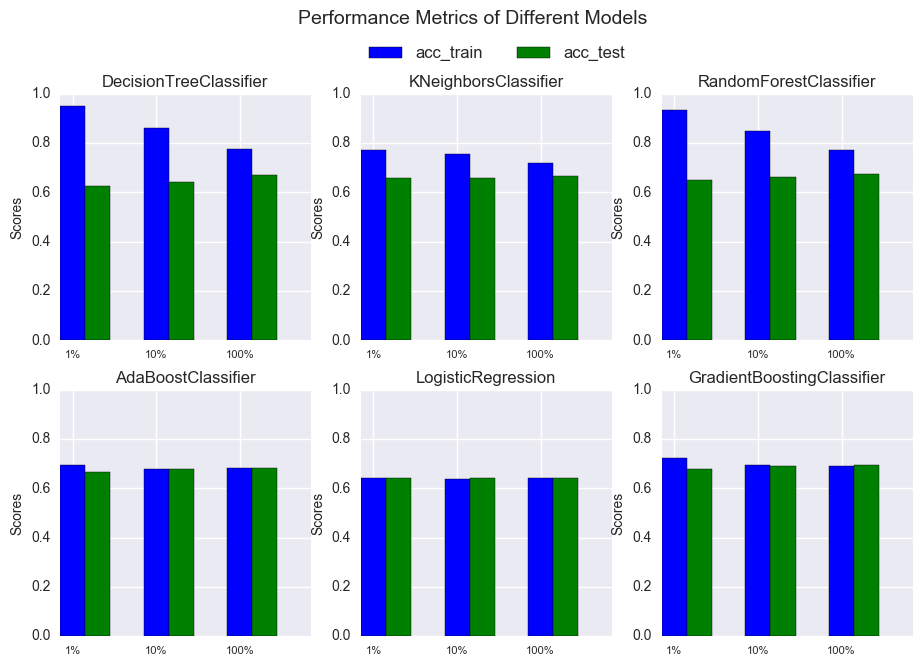

In [33]:
# compare accuracy scores of different models
model_performance(results, 'acc_train', 'acc_test')

All the above models achieve test accuracy over 60%, with decision tree, random forest and K nearest neighbor showing larger difference between training score and test score. AdaBoost and Gradient Boosting seem to give the best accuracy scores.

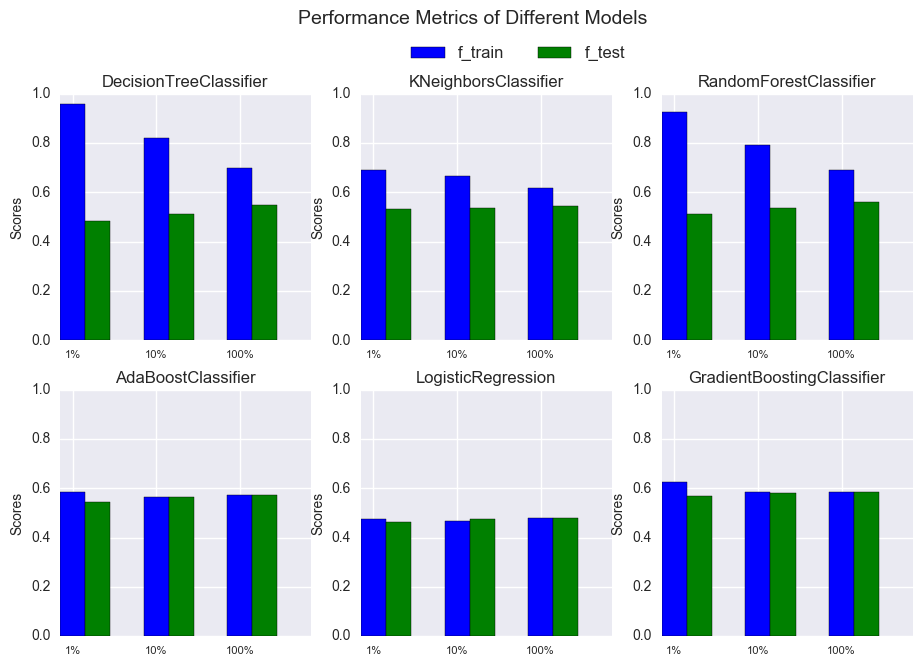

In [34]:
# f score
model_performance(results, 'f_train', 'f_test')

AdaBoost and Gradient Boosting give the best F scores.

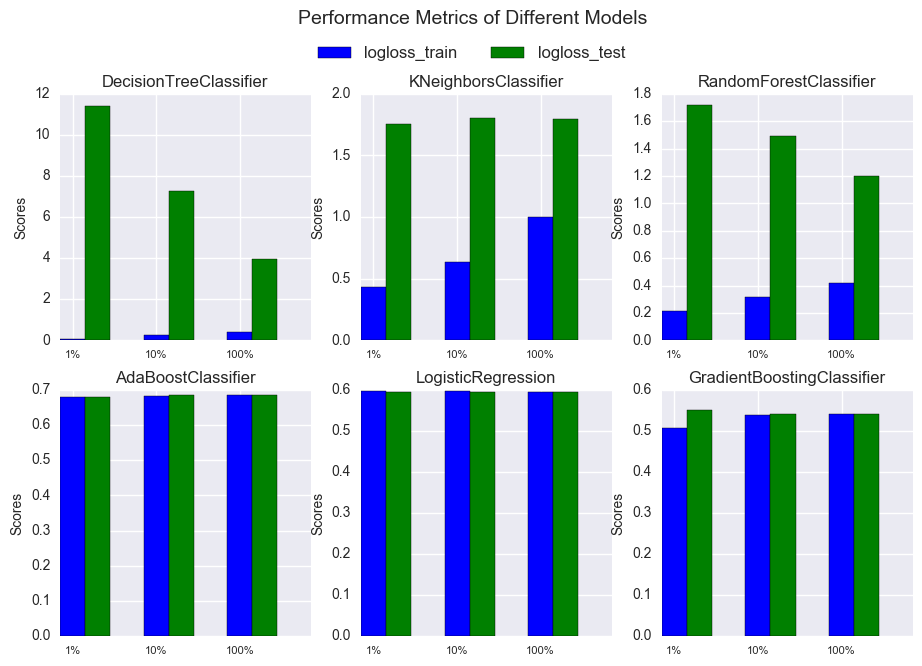

In [38]:
# log loss
fig, ax = plt.subplots(2, 3, figsize = (11,7))
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

for k, learner in enumerate(results.keys()):
    train_score = [results[learner][sample]['logloss_train'] for sample in [0, 1, 2]]
    test_score = [results[learner][sample]['logloss_test'] for sample in [0, 1, 2]]

    ax[k/3, k%3].bar(ind, train_score, width, color='blue')
    ax[k/3, k%3].bar(ind + width, test_score, width, color='green')

    # add some text for labels, title and axes ticks
    ax[k/3, k%3].set_title(learner)
    ax[k/3, k%3].set_ylabel('Scores', fontsize=10)
    ax[k/3, k%3].set_xticks(ind + width / 2)
    ax[k/3, k%3].set_xticklabels(('1%', '10%', '100%'), fontsize=8)
    
plt.legend(['logloss_train', 'logloss_test'], bbox_to_anchor = (-0.12, 2.42), \
               borderaxespad = 0., ncol = 2, fontsize=12)
plt.suptitle('Performance Metrics of Different Models', fontsize=14, y = 1.02)
plt.show()

**Gradient boosting** gives the smallest log loss among all the models for training/test sets. Decision tree and random forest, while giving small log loss for training data, result in high log loss for test data.

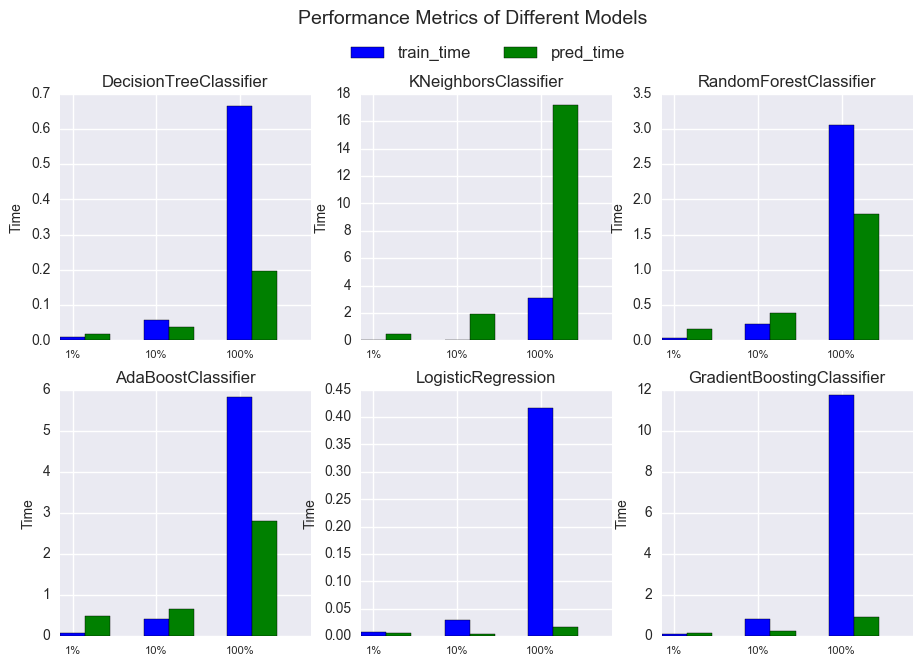

In [40]:
# model running time
fig, ax = plt.subplots(2, 3, figsize = (11,7))
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

for k, learner in enumerate(results.keys()):
    train_score = [results[learner][sample]['train_time'] for sample in [0, 1, 2]]
    test_score = [results[learner][sample]['pred_time'] for sample in [0, 1, 2]]

    ax[k/3, k%3].bar(ind, train_score, width, color='blue')
    ax[k/3, k%3].bar(ind + width, test_score, width, color='green')

    # add some text for labels, title and axes ticks
    ax[k/3, k%3].set_title(learner)
    ax[k/3, k%3].set_ylabel('Time', fontsize=10)
    ax[k/3, k%3].set_xticks(ind + width / 2)
    ax[k/3, k%3].set_xticklabels(('1%', '10%', '100%'), fontsize=8)
    
plt.legend(['train_time', 'pred_time'], bbox_to_anchor = (-0.12, 2.42), \
               borderaxespad = 0., ncol = 2, fontsize=12)
plt.suptitle('Performance Metrics of Different Models', fontsize=14, y = 1.02)
plt.show()

Gradient Boosting takes the longest time for training. K nearest neighbor, not suprisingly, takes the longest time for predicting.

## 4. Create a Submission File - GradientBoostingClassifier

Gradient Boosting show overall the best performance among the 6 models. So it is used to create the first non-constant classifier. Note that no hyperparameter tuning is performed. So this model just serves as a benchmark.

In [55]:
test = basic_feature(test)
feature_cols = ['delta_length', 'delta_num_words', 'delta_num_chars', 'num_share_words', 'ratio_share_words']
test_features = scaler.fit_transform(test[feature_cols])

In [56]:
clf = GradientBoostingClassifier(random_state=0)
features = scaler.fit_transform(features)
clf.fit(features, label)
pred = clf.predict_proba(test_features)

In [61]:
# 'pred' is a 2D array, giving the class probabilities of the input samples. 
# The order of the classes corresponds to that in the attribute classes_
clf.classes_

array([0, 1])

In [66]:
# so the 2nd probability number is the number to be submitted
pred_1 = [item[1] for item in pred]

In [67]:
# create submission file
ids = test['test_id']
submission = pd.DataFrame({'test_id': ids, 'is_duplicate': pred_1})
submission[['test_id', 'is_duplicate']].to_csv('./submission/GBC_v0', index = False)

The submission to Kaggle resulted in a log loss score of **0.48589**. Not bad! Next steps would be 
- to perform more sophisticated feature engineering 
- to tune the hyperparameters of the model
- to learn/try XGBoost and Keras